##Ambient Noise Waveforms Preprocessing Methods Examples##

The following notebook contains examples for using the psprocess.py toolbox for preprocessing raw seismic waveforms to a point where they can be used for cross-correlations. Currently the script can only operate with MSEED formats, but additional support for other formats such as: SAC, SEED and SUDS will likely be added in the future. The user specifies the input path to the raw waveform. This waveform should be only one trace for the purposes of this example, e.g. BHZ. A Preprocess object is created with this input, and the output is specified by one of the functions contained. 

The theory for the current workflow that this example follows for preprocessing is explained in depth in Bensen et al. (2007).

In [44]:
from pysismo.pspreprocess import Preprocess
from obspy import read 
from obspy.core import Stream
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

The Preprocess class requires many input parameters to function. Below is a list of examples.

In [45]:
# list of example variables for Preprocess class
FREQMAX = 1./1                            # bandpass parameters
FREQMIN = 1/20.0
CORNERS = 2
ZEROPHASE = True 
ONEBIT_NORM = False                       # one-bit normalization
PERIOD_RESAMPLE = 0.02                     # resample period to decimate traces, after band-pass
FREQMIN_EARTHQUAKE = 1/75.0               # earthquakes periods band
FREQMAX_EARTHQUAKE = 1/25.0   
WINDOW_TIME = 0.5 * 1./FREQMAX_EARTHQUAKE # time window to calculate time-normalisation weights
WINDOW_FREQ = 0.0002                      # freq window (Hz) to smooth ampl spectrum

# here is a list of all of the functions and variables that the Preprocess class contains
help(Preprocess)

Help on class Preprocess in module pysismo.pspreprocess:

class Preprocess
 |  Class for performing all possible preprocess steps on a seismic waveform
 |  to then allow for smooth cross-correlation.
 |  
 |  @param freqmin: low frequency of the band-pass filter
 |  @param freqmax: high frequency of the band-pass filter
 |  @param freqmin_earthquake: low frequency of the earthquake band
 |  @param freqmax_earthquake: high frequency of the earthquake band
 |  @param corners: nb or corners of the band-pass filter
 |  @param zerophase: set to True for filter not to shift phase
 |  @type zerophase: bool
 |  @param period_resample: resampling period in seconds
 |  @param onebit_norm: set to True to apply one-bit normalization (else,
 |                      running mean normalization is applied)
 |  @type onebit_norm: bool
 |  @param window_time: width of the window to calculate the running mean
 |                      in the earthquake band (for the time-normalization)
 |  @param window_fre

In [46]:
# set the path to the desired waveform, the example HOLS.mseed is provided. 
example_path = 'tools/examples/HOLS.mseed'

# import a trace from the example waveform
example_trace = read(example_path)[0]
# initialise the Preprocess class
PREPROCESS = Preprocess(FREQMIN, FREQMAX, FREQMIN_EARTHQUAKE, 
                        FREQMAX_EARTHQUAKE, CORNERS, ZEROPHASE, 
                        PERIOD_RESAMPLE, WINDOW_TIME, WINDOW_FREQ, 
                        ONEBIT_NORM)

The following processing examples are in order from Bensen et al. (2007). The final example has all of them combined.
-    First, the trace has its instrument response removed. 
-    Second, the trace is trimmed, demeaned and detrended. 
-    Third, the trace is passed through a butterworth band-pass filter to remove high amplitude noise and event signals as much as possible.
-    Fourth, the trace is downsampled to allow for swifter processing. The closer to the original sample rate this is left, the longer overall processing will take!
-    Fifth, the trace is normalised. This can be specified as either time-normalised or one-bit normalised.
-    Sixth, the spectrum of the waveform is 'whitened'.

Take note that for the purposes of this example, the instrument response has been kept. This is because the metadata file for this waveform is having some technical difficulties. The resulting waveforms and techniques posed here are still valid for example purposes. 

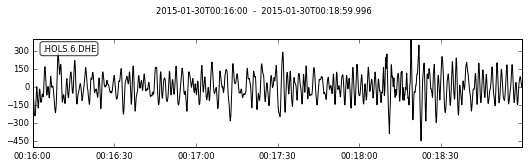

In [47]:
# process the band-pass filtered trace
# the bands are set from the above freqmax and freqmin parameters entered when the class is initialised.
example_trace = PREPROCESS.bandpass_filt(example_trace)
st = Stream(traces=[example_trace])
st.plot()

Next, downsample the example_trace. The output downsampled trace is dictated by the variable PERIOD_RESAMPLE. The new sample rate is 1/PERIOD_RESAMPLE

In [48]:
# Previous trace sample rate:
print 'Initial trace sample rate: ', example_trace.stats.sampling_rate
# Downsample trace
example_trace = PREPROCESS.trace_downsample(example_trace)
print 'Downsampled trace sample rate: ', example_trace.stats.sampling_rate

Initial trace sample rate:  250.0
<class 'obspy.core.trace.Trace'>
Downsampled trace sample rate:  50.0


Normalise the trace, either with respect to time, or the one-bit normalisation procedure. 

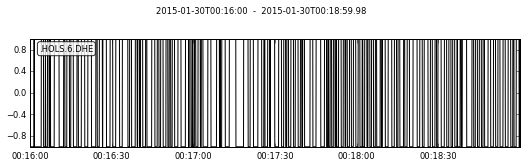

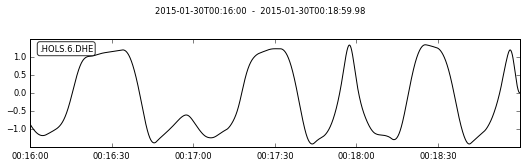

In [49]:
example_trace_copy = example_trace
# one-bit normalization
example_trace.data = np.sign(example_trace.data)
st = Stream(traces=[example_trace])
# plot the one-bit normalised trace
st.plot()

# copy the trace for time normalisation
example_trace = example_trace_copy
# process for time normalisation
example_trace = PREPROCESS.time_norm(example_trace, example_trace_copy)
st = Stream(traces=[example_trace])
# plot the time normalised trace
st.plot()



Finally spectrally whiten the trace.

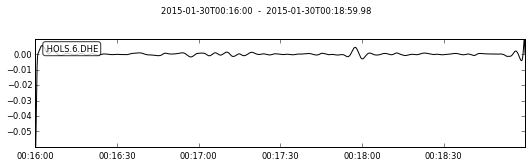

In [50]:
# process the whitened spectrum for the trace
example_trace = PREPROCESS.spectral_whitening(example_trace)
st = Stream(traces=[example_trace])
# plot the time normalised trace
st.plot()

##References##

Bensen, G., Ritzwoller, M., Barmin, M., Levshin, A., Lin, F., & Moschetti, M. et al. (2007). Processing seismic ambient noise data to obtain reliable broad-band surface wave dispersion measurements. Geophysical Journal International, 169(3), 1239-1260. doi:10.1111/j.1365-246x.2007.03374.x